In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

In [2]:
"""
卷积运算 使用mnist数据集，和10-4，11类似的，只是这里：1.输出训练轮的acc 2.模型上使用torch.nn.Sequential
"""
# Super parameter ------------------------------------------------------------------------------------
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

In [3]:
# Prepare dataset ------------------------------------------------------------------------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# softmax归一化指数函数(https://blog.csdn.net/lz_peter/article/details/84574716),其中0.1307是mean均值和0.3081是std标准差

In [6]:
train_dataset = datasets.MNIST(root='./data/mnist', train=True, transform=transform, download=True)  # 本地没有就加上download=True
test_dataset = datasets.MNIST(root='./data/mnist', train=False, transform=transform, download=True)  # train=True训练集，=False测试集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 932kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.66MB/s]


c:\Users\86184\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\86184\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


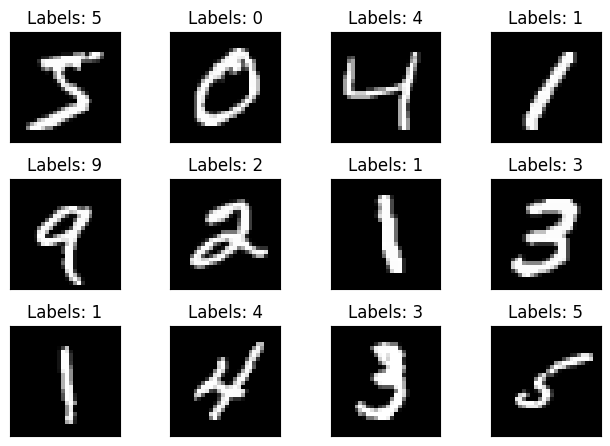

In [7]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
# 训练集乱序，测试集有序
# Design model using class ------------------------------------------------------------------------------
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）


model = Net()


# Construct loss and optimizer ------------------------------------------------------------------------------
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

In [12]:
# Train and Test CLASS --------------------------------------------------------------------------------------
# 把单独的一轮一环封装在函数类里
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

    torch.save(model, f'./models/model_Mnist_{epoch+1}.pth')
    torch.save(optimizer.state_dict(), f'./optimizers/optimizer_Mnist_{epoch+1}.pth')

In [13]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

[1,   300]: loss: 0.032 , acc: 99.08 %
[1,   600]: loss: 0.033 , acc: 98.93 %
[1,   900]: loss: 0.031 , acc: 99.07 %
[1 / 10]: Accuracy on test set: 98.9 % 
[2,   300]: loss: 0.031 , acc: 99.09 %
[2,   600]: loss: 0.031 , acc: 99.01 %
[2,   900]: loss: 0.030 , acc: 99.10 %
[2 / 10]: Accuracy on test set: 98.9 % 
[3,   300]: loss: 0.028 , acc: 99.18 %
[3,   600]: loss: 0.027 , acc: 99.20 %
[3,   900]: loss: 0.031 , acc: 99.06 %
[3 / 10]: Accuracy on test set: 98.8 % 
[4,   300]: loss: 0.027 , acc: 99.20 %
[4,   600]: loss: 0.026 , acc: 99.21 %
[4,   900]: loss: 0.031 , acc: 99.10 %
[4 / 10]: Accuracy on test set: 99.0 % 
[5,   300]: loss: 0.024 , acc: 99.32 %
[5,   600]: loss: 0.026 , acc: 99.17 %
[5,   900]: loss: 0.027 , acc: 99.23 %
[5 / 10]: Accuracy on test set: 98.8 % 
[6,   300]: loss: 0.026 , acc: 99.23 %
[6,   600]: loss: 0.023 , acc: 99.36 %
[6,   900]: loss: 0.025 , acc: 99.16 %
[6 / 10]: Accuracy on test set: 98.9 % 
[7,   300]: loss: 0.023 , acc: 99.25 %
[7,   600]: loss: 0

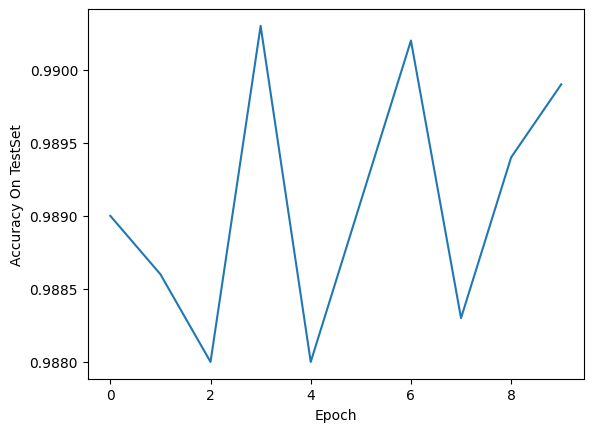

In [15]:
# Start train and Test --------------------------------------------------------------------------------------
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()